# SOA 2019 Predictive Modeling, Innovation and Industry Contest 
# Computer Vision in Healthcare

## Executive Summary


The proposal for the Society of Actuaries (SOA) 2019 Predictive Modeling, Innovation and Industry Contest, is aimed to illustrate the potential of computer vision algorithms in healthcare. The primary objective is to design computer vision algorithms that improve diagnosis accuracy by reducing false positives and false negatives. The current proposal studies the  HAM10000, Human Against Machine 10000, a dermatostopic image database [1]. The objective of the algorithm is to classify images of seven skin conditions, malignant, and non malignant, which include: Actinic Keratoses, Basal cell carcinoma, Benign keratosis, Dermatofibroma, Melanocytic nevi, Melanoma, and Vascular skin lesions. The algorithm presented is based on a Convolutional Neural Network (CNN), with ResNet50 [2] backbone, pre-trained on Imagenet weights and fine tuned with the current data. The winners of the International Skin Imaging Collaboration (ISIC) 2018 challlenge achieved a balanced multiclass accuracy of 88.5% in the competition test set. Unfortunately, the ISIC 2018 leaderboard is not accepting new submissions so we can not replicate the score on the test set. However, we replicated the 5-fold cross-validation score as reported by the winners of the challenge. Our algorithm achieves 67.9% balanced multiclass accuracy using 5-fold cross-validation on ResNet50, using only the 10,015 training samples. This result is similar to the 72.1% to 77.0% 5 fold cross-validation scores of ResNet-50 reported by the competition winners, that used 47,822 training samples. Our proposed algorithm uses only one neural network trained on ResNet50. The winners of the ISIC 2018 challenge used an ensemble of more than five models and external data, which is computationally more expensive [3]. 



This artificial intelligence tool is aimed primarily for primary care physicians, as they refer to specialist level of care. With a more accurate diagnosis, the use of dermatological care and biopsies may be reduced, reducing overall healthcare costs. The tool could also be used by health insurance companies to validate their diagnosis, aid in the underwritting process and evaluate providers in terms of diagnosis accuracy [4]. This tool is not intended to replace the dermatologist judgment, as an underlying condition may have different risk factors (such as age, gender, progression of the lesion, etc.) that are not captured by these artificial intelligence (AI) tools based on image data only. 



## Introduction


Applications of computer vision in healthcare are numerous. Several examples include: X-ray pneumonia detection [5], breast cancer classification [6], skin cancer detection, [7] among others. An example of a start up that leverages this technology is entilic https://www.enlitic.com/. Entilic specializes in helping radiologists interpret X-rays, CT scans and MRI studies, in order to prioritize their work. Entilic claims that it has discovered malignant tumor nodules up to 18 months faster than standard of care.

An SOA report (Shang, 2018) highlights the importance of computer vision in insurance applications [4]. In this article, the author presents a solution to a distracted driver problem, using CNNs, and also describes the potential of computer vision in other insurance areas, such as underwritting and healthcare. Our proposal focuses on providing more details of the implementation of computer vision techniques in healthcare. In particular, our proposal focuses on skin cancer detection, but the analysis can be extrapolated to other health conditions. As noted by Shang (2018), medical images can provide richer information for health insurance underwriting and pricing.

The jupyter notebook is divided in several sections. First, we will present a brief overview of the technical requirements to run computer vision models. Second, we will provide a descriptive analysis of the HAM10000 dataset. After that we will cover the model set up, and the creation of the training and validation sets using cross-validation. The next step will illustrate the CNN architecture ResNet50, and the selection of the model parameters. A final step will describe the analysis of the results, and the limitations of the analysis. 

## Problem Definition and Risks


Computer vision has a lot of applications in the health insurance marketplace. As noted by Shang, 2018, health insurance is an area where image recognition can provide more insight regarding the risk of individual customers. Physicians can use image recognition for diagnosis and prognosis [4]. In addition to linking doctors’ opinions to insurance pricing, given enough image data and claim experience, medical images such as computed tomography (CT)  images of cancer patients may be used directly as pricing factors to help underwriting and derive risk loading and insurance premium rate [4]. 


Shang, 2018, also notes the risk of the computer vision models. Regulatory and reputational risk may also occur with the application of image recognition [4]. Image data may not be considered private and thus may be judged inappropriate for determining insurance rate and claim [4]. If an insurance company does not fully explain its methods to customers, regulators and the public, using nonpublic image data could cause reputational incidents [4]. Even if the data are usable, the way they are used to assess risks and determine insurance premium may be questioned [4]. Clients may want to know exactly how the algorithm determines the risk loading for insurance products [4]. Insurers that want to use image recognition technology need to be prepared for explanation and communication [4]. 

## Technical Details

This notebook was created using Jupyter notebook version 5.6.0, and Python 3.7.0. The operating sytem used is Ubuntu 18.04, on a computer using an NVIDIA 2080 GPU card (8GB memory size). For image processing, the use of a solid state hard drive is recommended to speed the training process due to the number of read and write operations involved in the training of computer vision models.

This notebook uses a Graphic Processing Unit NVIDIA GPU. Configuration instructions for the deep learning environment are available on the NVIDIA website https://docs.nvidia.com/deeplearning/sdk/cudnn-install/index.html. 

The Python libraries used for the analysis include: fastai (version 1.0.56.dev0), a machine learning library that includes code for computer vision models, pandas (version 0.24.2), a library for data manipulation, sklearn (version 0.20.2) for selection of the training, validation, and test sets and for calculation of important metrics, cv2 (version 3.4.3), for image processing, and matplotlib (version 3.0.0), for general purpose graphics.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt

#Create symbolic link for fastai path - only once
#! ln -s /home/username/fastai/fastai


#Load libraries
import fastai
import sklearn

from fastai.vision import *
import pandas as pd # For data manipulation

from fastai.callbacks import *


from sklearn.model_selection import train_test_split



import cv2
import matplotlib 

print ("fastai version", fastai.__version__)
print ("Pandas version", pd.__version__)
print ("sklearn version", sklearn.__version__)

print ("cv2", cv2.__version__)
print ("matplotlib", matplotlib.__version__)


#To handle LaTeX references
#https://github.com/Jupyter-contrib/jupyter_nbextensions_configurator
#!pip install jupyter_nbextensions_configurator
#jupyter nbextensions_configurator enable --user
#!pip install jupyter_contrib_nbextensions
#!jupyter contrib nbextension install --user

fastai version 1.0.56.dev0
Pandas version 0.24.2
sklearn version 0.20.2
cv2 3.4.3
matplotlib 3.0.0


## Data Analysis

The HAM10000 database (Human Against Machine with 10000 training images), contains 10015 dermatoscopic images which are released as a training set for academic machine learning purposes [1]. The database is publicly available at https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T, and it is released under a Creative Commons Attribution-NonCommercial 4.0 International Public License.

The HAM10000 database database contains 10,015 images of skin conditions corresponding to 7,470 unique lesions, whith some lesions having as many as six pictures. We assume that each lesion corresponds to an independent patient. The database includes information for seven diagnosis including: Actinic Keratoses (Solar Keratoses) and Intraepithelial Carcinoma (Bowen’s disease) (akiec) (N=228), Basal cell carcinoma (bcc) (N=327), Benign keratosis (bkl) (N=727), Dermatofibroma (df) (N=73), Melanocytic nevi (nv) (N=5,403), Melanoma (mel) (N=614), and Vascular skin lesions (vasc) (N=98). The average age of the patients in the database is 52 years (standard deviation 16 years) (N = 7,418; 0.70 % missing data) with a minimumm age of 0 months and maximum age of 85 years, and 54% male gender (N = 4,001). The images of the lessions come from fifteen diferent regions, such as lower extremity 21% (N=1,584), back 21% (N= 1,534), trunk 17%(N= 1,269), abdomen 11% (N=822), and others 30% (N=2,261). 

As can be seen from the frequency counts of the skin conditions, we have an unbalanced classification problem, with the most prevalent diagnosis being Melanocytic nevi (N = 5,403 patients) and the least prevalent diagnosis being Dermatofibroma (N=73 patients).

### Data Quality

Data was reviewed for consistency according to the Actuarial Standards of Practice (ASOP) 23. The metadata is believed to be adequate for the purposes of this analysis, with a small percentage of missing data in the age field (0.70 % missing data N = 52 patients), and we didn't identify any potential outliers. For the image data, Tschandl, et. al [1] state that they perform manual changes to image histograms to correct for over/under exposure and undesiredcolour shifts. Aditionally, Tschandl, et al [1] also state that more than 50% of lesions have been confirmed by pathology, while the ground truth for the rest of the cases was either follow-up, expert consensus, or confirmation by in-vivo confocal microscopy. Therefore, the data is deemed apropriate for the purposes of this analysis. However, material changes in the data could potentially yield to significant changes in the inference.

### Load Metadata 

In [2]:
#Load metadata
metadata = pd.read_csv('/home/user/Documents/HAM_Dataset/HAM10000_metadata.csv')

In [3]:
#Path to the folder containing the images
 
path_img = '/home/user/Documents/HAM_Dataset/Data/'


In [4]:
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [5]:
patient_data = metadata.drop_duplicates(['lesion_id'])

### Descriptive analysis of the Data

In [6]:
metadata.describe(include='all')

,lesion_id,image_id,dx,dx_type,age,sex,localization
count,10015,10015,10015,10015,9958.000000,10015,10015
unique,7470,10015,7,4,NaN,3,15
top,HAM_0001863,ISIC_0031764,nv,histo,NaN,male,back
freq,6,1,6705,5340,NaN,5406,2192
mean,NaN,NaN,NaN,NaN,51.863828,NaN,NaN
std,NaN,NaN,NaN,NaN,16.968614,NaN,NaN
min,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,40.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,50.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,65.000000,NaN,NaN


In [7]:
patient_data.describe(include='all')

,lesion_id,image_id,dx,dx_type,age,sex,localization
count,7470,7470,7470,7470,7418.000000,7470,7470
unique,7470,7470,7,4,NaN,3,15
top,HAM_0002673,ISIC_0031764,nv,follow_up,NaN,male,lower extremity
freq,1,1,5403,3704,NaN,4001,1584
mean,NaN,NaN,NaN,NaN,51.658803,NaN,NaN
std,NaN,NaN,NaN,NaN,16.016472,NaN,NaN
min,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,40.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,50.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,65.000000,NaN,NaN


In [8]:
patient_data['dx'].value_counts()

nv       5403
bkl       727
mel       614
bcc       327
akiec     228
vasc       98
df         73
Name: dx, dtype: int64

In [9]:
patient_data['sex'].value_counts()

male       4001
female     3419
unknown      50
Name: sex, dtype: int64

In [10]:
patient_data['localization'].value_counts() 

lower extremity    1584
back               1534
trunk              1269
abdomen             822
upper extremity     776
face                470
chest               240
foot                228
unknown             203
neck                119
scalp                78
hand                 64
genital              45
ear                  35
acral                 3
Name: localization, dtype: int64

### Selected Examples of the Skin Conditions 

Below we present an example image of each of the seven skin conditions studied in this database. The goal of the computer vision algorithm is to predict given an image, which one of the seven skin conditions the image corresponds to.

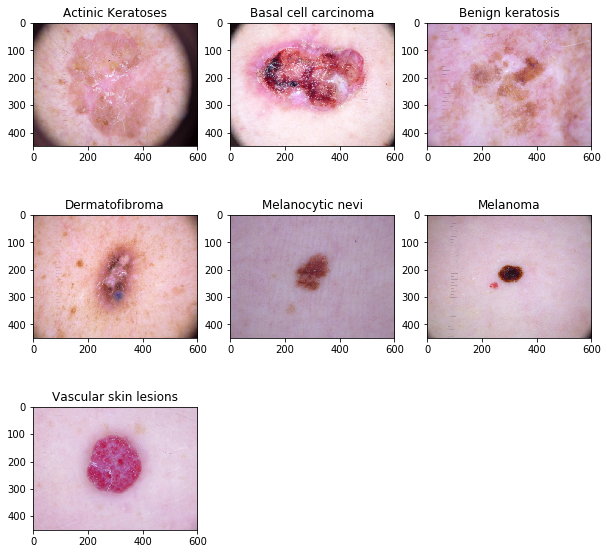

In [90]:
#Selected Examples of the Lessions
#Set path 
path_img = '/home/user/Documents/HAM_Dataset/Data/'

import warnings
warnings.filterwarnings("ignore")

#function taken from https://www.datacamp.com/community/tutorials/face-detection-python-opencv
def convertToRGB(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(10,10))

#akiec ISIC_0029417

ax1 = fig.add_subplot(331)
ax1.set_title('Actinic Keratoses')
ax1 = cv2.imread(path_img + 'ISIC_0029417.jpg')
ax1 = plt.imshow(convertToRGB(ax1))

#bcc ISIC_0028155

ax2 = fig.add_subplot(332)
ax2.set_title('Basal cell carcinoma')
ax2 = cv2.imread(path_img + 'ISIC_0028155.jpg')
ax2 = plt.imshow(convertToRGB(ax2))

#bkl ISIC_0027419
ax3 = fig.add_subplot(333)
ax3.set_title('Benign keratosis')
ax3 = cv2.imread(path_img + 'ISIC_0027419.jpg')
ax3 = plt.imshow(convertToRGB(ax3))

#df ISIC_0027008
ax4 = fig.add_subplot(334)
ax4.set_title('Dermatofibroma')
ax4 = cv2.imread(path_img + 'ISIC_0027008.jpg')
ax4 = plt.imshow(convertToRGB(ax4))

#nv ISIC_0024698
ax6 = fig.add_subplot(335)
ax6.set_title('Melanocytic nevi')
ax6 = cv2.imread(path_img + 'ISIC_0024698.jpg')
ax6 = plt.imshow(convertToRGB(ax6))

#mel ISIC_0025964
ax5 = fig.add_subplot(336)
ax5.set_title('Melanoma')
ax5 = cv2.imread(path_img + 'ISIC_0025964.jpg')
ax5 = plt.imshow(convertToRGB(ax5))

#vasc ISIC_0031197
ax7 = fig.add_subplot(337)
ax7.set_title('Vascular skin lesions')
ax7 = cv2.imread(path_img + 'ISIC_0031197.jpg')
ax7 = plt.imshow(convertToRGB(ax7))

fig.show()

## Creation of the training and validation sets

The next step in the modeling process is the creation of the training and validation sets. We do that using 5-fold stratified cross validation to get folds that have similar proportions of every diagnosis. Since there are several lesions with repeated pictures, we make sure that no lesions overlap between the train and validation sets. Doing so is called a validation set leakage, and will most likely cause overfitting, as the model will learn to memorize the images of a particular condition and not generalize well in unseen data.

In [12]:
#Creation of a database by lession id

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=42)

lesion_id = pd.DataFrame({'lesion_id':list(metadata['lesion_id'].value_counts().index)})

patient_data = metadata.drop_duplicates(['lesion_id'])
patient_data = patient_data.reset_index(drop=True)
X = patient_data['lesion_id']
y = patient_data['dx']


In [13]:
train_1, train_2, train_3, train_4, train_5 = [patient_data.loc[i[0]] for i in skf.split(X, y)]

In [14]:
valid_1, valid_2, valid_3, valid_4, valid_5 = [patient_data.loc[i[1]] for i in skf.split(X, y)]

In [15]:
train_1 = train_1.assign(database = "train")
train_1 = train_1.assign(is_validation = False)
valid_1 = valid_1.assign(database = "validation")
valid_1 = valid_1.assign(is_validation = True)

In [16]:
train_2 = train_2.assign(database = "train")
train_2 = train_2.assign(is_validation = False)
valid_2 = valid_2.assign(database = "validation")
valid_2 = valid_2.assign(is_validation = True)

train_3 = train_3.assign(database = "train")
train_3 = train_3.assign(is_validation = False)
valid_3 = valid_3.assign(database = "validation")
valid_3 = valid_3.assign(is_validation = True)

train_4 = train_4.assign(database = "train")
train_4 = train_4.assign(is_validation = False)
valid_4 = valid_4.assign(database = "validation")
valid_4 = valid_4.assign(is_validation = True)

train_5 = train_5.assign(database = "train")
train_5 = train_5.assign(is_validation = False)
valid_5 = valid_5.assign(database = "validation")
valid_5 = valid_5.assign(is_validation = True)

In [17]:
#Concatenate the databases
metadata_train_valid = pd.concat([train_1, valid_1]) 
metadata_train_valid2 = pd.concat([train_2, valid_2])
metadata_train_valid3 = pd.concat([train_3, valid_3])
metadata_train_valid4 = pd.concat([train_4, valid_4])
metadata_train_valid5 = pd.concat([train_5, valid_5])


In [18]:
metadata_train_valid = pd.merge(metadata, metadata_train_valid[['lesion_id', 'is_validation']], on=['lesion_id'])
metadata_train_valid2 = pd.merge(metadata, metadata_train_valid2[['lesion_id', 'is_validation']], on=['lesion_id'])
metadata_train_valid3 = pd.merge(metadata, metadata_train_valid3[['lesion_id', 'is_validation']], on=['lesion_id'])
metadata_train_valid4 = pd.merge(metadata, metadata_train_valid4[['lesion_id', 'is_validation']], on=['lesion_id'])
metadata_train_valid5 = pd.merge(metadata, metadata_train_valid5[['lesion_id', 'is_validation']], on=['lesion_id'])

In [19]:
pd.crosstab(metadata_train_valid.dx, metadata_train_valid.is_validation) #metadata_train_valid['dx'].value_counts()

is_validation,False,True
dx,,
akiec,268,59
bcc,400,114
bkl,810,289
df,88,27
mel,890,223
nv,5623,1082
vasc,105,37


In [20]:
pd.crosstab(metadata_train_valid2.dx, metadata_train_valid2.is_validation) #metadata_train_valid2['dx'].value_counts()

is_validation,False,True
dx,,
akiec,262,65
bcc,396,118
bkl,914,185
df,85,30
mel,847,266
nv,5624,1081
vasc,99,43


In [21]:
pd.crosstab(metadata_train_valid3.dx, metadata_train_valid3.is_validation) #metadata_train_valid3['dx'].value_counts()

is_validation,False,True
dx,,
akiec,256,71
bcc,435,79
bkl,886,213
df,85,30
mel,857,256
nv,5624,1081
vasc,118,24


In [22]:
pd.crosstab(metadata_train_valid4.dx, metadata_train_valid4.is_validation) # metadata_train_valid4['dx'].value_counts()

is_validation,False,True
dx,,
akiec,251,76
bcc,412,102
bkl,847,252
df,101,14
mel,942,171
nv,4882,1823
vasc,123,19


In [23]:
pd.crosstab(metadata_train_valid5.dx, metadata_train_valid5.is_validation) #metadata_train_valid5['dx'].value_counts()

is_validation,False,True
dx,,
akiec,271,56
bcc,413,101
bkl,939,160
df,101,14
mel,916,197
nv,5067,1638
vasc,123,19


## Modeling 

The training takes place in the fastai library [8], which sits on top of a popular AI library Pytorch. Installation instructions for the fastai library can be found at https://docs.fast.ai/install.html. 

The architecture selected for the CNN is ResNet50 [2], pre-trained on imagenet weights. ResNet is a popular architecture for training deep neural networks that uses a residual learning framework [2]. We initialize the network weights using Imagenet. Training takes place in two stages, first with image size to 224 * 224, we train only the heads (this is the last part of the network), then we unfreeze the other layers and train the rest of the network.  Original image size is 600 * 450.

To train the neural network we need to normalize the data, to do so, we calculate the statistics of the images mean and standard deviation, and use this to normalize the image set.

## Model parameters

Drop out regularization, a method to remove connections to reduce overfitting, was set to 50%.

Batch size:  This is the number of images that get processed by the learning process at a time. This depends on the GPU memory. In this case, using an NVIDIA 2080 card we can accomodate 32 images of size 224 * 224.  

Loss Function: We optimize the loss function cross entropy loss with weights. To deal with class imbalance we use the inverse of the frequency of each one of the seven skin conditions. This is, the loss function gets penalized more heavily if the prediction of a rare class is wrong. If we don't use a penalized loss function, the network tends to predict the most frequent class.

Learning rate: After we create the weights, we also need to find the learning rate. This is one of the most important parameters when training neural networks. We use this by using cyclical learning rates as described in https://arxiv.org/abs/1506.01186.

Data augmentation is also a technique to artificially create new data and reduce overfitting. This is availabe in fastai, with the function tfms = get_transforms(flip_vert = True). The transformations applied to the data are: random flip, flip vertical, rotation, zoom, a random lightning and contrast change, and a random symmetric warp.

Test time augmentation was used at the end of every fold to improve the accuracy of the predictions. This is accomplished by taking every image, applying transformations, and taking the average of all of the predictions. 

In [24]:
#Make the training process deterministic 
#function taken from kernel https://www.kaggle.com/iafoss/hypercolumns-pneumothorax-fastai-0-831-lb

SEED = 2019

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    #tf.set_random_seed(seed)
seed_everything(SEED)


In [25]:
#Normalization statistics 
import cv2


img_stats = []

def open_image(fname):
    img = cv2.imread(os.path.join(path_img, fname + '.jpg'))/255
    #img = cv2.resize(img, (sz, sz)) / 255
    x_tot = img.mean() #image statistics
    x2_tot = (img**2).mean()
    
    return x_tot, x2_tot


for fname in metadata['image_id']:
    img_stats.append(open_image(fname))


In [26]:

#function taken from https://www.kaggle.com/iafoss/data-repack-and-image-statistics
def get_stats(stats): # get dataset statistics 
    x_tot, x2_tot = 0.0, 0.0
    for x, x2 in stats:
        x_tot += x
        x2_tot += x2
    
    img_avr =  x_tot/len(stats)
    img_std =  np.sqrt(x2_tot/len(stats) - img_avr**2)
    print('mean:',img_avr, ', std:', img_std)
    
    
get_stats(img_stats)



mean: 0.6267264561492303 , std: 0.18320752802569892


# Fold 1

In [28]:
epochs_head = 4
epochs_all = 15
patience = 3

In [29]:
from sklearn.metrics import confusion_matrix


In [30]:
#Class weights to deal with class imbalance
#New weights - inverse of class frequency

sample_size = 10015
num_classes = 7


w1 = sample_size/(327)
w2 = sample_size/(514)
w3 = sample_size/(1099)
w4 = sample_size/(115)
w5 = sample_size/(1113)
w6 = sample_size/(6705) 
w7 = sample_size/(142)


weights = [w1, w2, w3, w4, w5, w6, w7]
class_weights = torch.FloatTensor(weights).cuda()


print(weights)

[30.62691131498471, 19.48443579766537, 9.112829845313922, 87.08695652173913, 8.998203054806828, 1.493661446681581, 70.52816901408451]


In [31]:
#Increase image size


gc.collect()

bs = 32 #batch size - depends on the GPU memory and number of GPUs available. For The current GPU we have 2080 with
#memory 8GB, we can use bs =16


def get_data(metadata_train_valid, bs, size):
    stats = ([0.626, 0.626, 0.626], [0.1829, 0.1829, 0.1829])
    
    data = (ImageList.from_df(metadata_train_valid, path_img, cols='image_id', suffix='.jpg')
        .split_from_df(col='is_validation')
        .label_from_df(cols='dx')
        .transform(size=(size, size), tfms = get_transforms(flip_vert = True))
        .databunch(bs=bs)).normalize(stats)
    
    return data


data = get_data(metadata_train_valid, bs, 224)

#Define Convolutional Neural Network with backbone resnet50
learn = cnn_learner(data, models.resnet50, metrics = [error_rate, accuracy],
                   callback_fns=[ShowGraph])

learn.loss_func=nn.CrossEntropyLoss(weight=class_weights)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


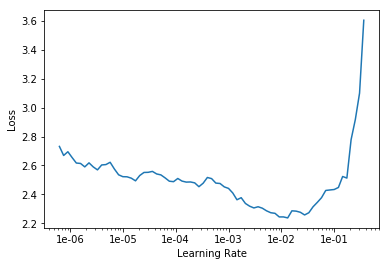

In [32]:
#Learn rate finder
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.495504,1.219684,0.426543,0.573457,00:43
1,0.939320,0.888996,0.320044,0.679956,00:45
2,0.816192,0.945954,0.344074,0.655926,00:43
3,0.704094,0.787698,0.287821,0.712179,00:44


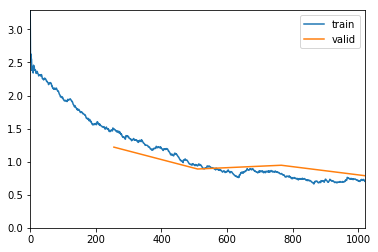

Better model found at epoch 0 with accuracy value: 0.5734571218490601.
Better model found at epoch 1 with accuracy value: 0.679956316947937.
Better model found at epoch 3 with accuracy value: 0.7121791243553162.


In [33]:
#Fit heads
seed_everything(SEED)

learn.clip_grad(1.0);

lr = 1e-3
learn.fit_one_cycle(epochs_head, max_lr = lr,   
                    callbacks=[SaveModelCallback(learn, monitor='accuracy',
                                                 mode='max', name='Best_model_sz224_resnet50_fold1')])

In [34]:
learn.load('Best_model_sz224_resnet50_fold1')
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


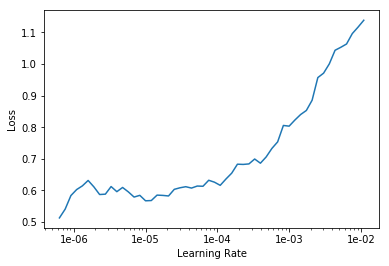

In [35]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.630204,0.839754,0.301475,0.698525,00:59
1,0.641056,0.834359,0.301475,0.698525,00:59
2,0.691175,0.804068,0.290005,0.709995,00:59
3,0.599363,0.784751,0.283452,0.716548,00:58
4,0.623151,0.802924,0.286729,0.713271,00:58
5,0.603048,0.836452,0.299290,0.700710,00:58
6,0.617417,0.847394,0.296013,0.703987,00:58
7,0.517802,0.794418,0.285636,0.714364,00:58
8,0.539848,0.791049,0.280721,0.719279,00:58
9,0.522666,0.799893,0.285090,0.714910,00:58


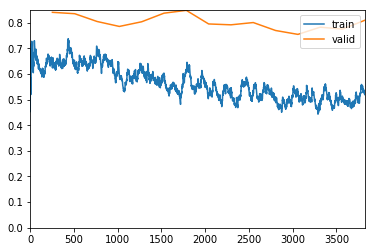

Better model found at epoch 0 with accuracy value: 0.6985253691673279.
Better model found at epoch 2 with accuracy value: 0.7099945545196533.
Better model found at epoch 3 with accuracy value: 0.7165483236312866.
Epoch 7: reducing lr to 1.4996633150096014e-06
Better model found at epoch 8 with accuracy value: 0.7192791104316711.
Better model found at epoch 10 with accuracy value: 0.7252867221832275.
Better model found at epoch 11 with accuracy value: 0.7362097501754761.


In [36]:
learn.fit_one_cycle(epochs_all, max_lr = slice(1e-6, 1e-5), wd=0.05, 
                    callbacks=[SaveModelCallback(learn, monitor='accuracy',
                              mode='max', name='Best_model_sz224_stage2_resnet50_fold1'),
                              ReduceLROnPlateauCallback(learn, monitor='accuracy', 
                              mode='max', patience = patience)])

In [37]:
learn.load('Best_model_sz224_stage2_resnet50_fold1')

interp1 = ClassificationInterpretation.from_learner(learn)
print(interp1.confusion_matrix().sum())

losses,idxs = interp1.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)


1831


True

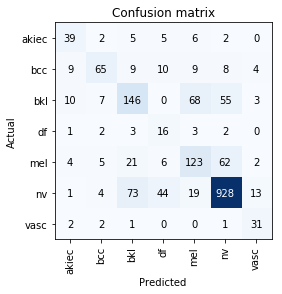

In [38]:
interp1.plot_confusion_matrix()

In [39]:
confusion_matrix1 = interp1.confusion_matrix()

FP = confusion_matrix1.sum(axis=0) - np.diag(confusion_matrix1)  
FN = confusion_matrix1.sum(axis=1) - np.diag(confusion_matrix1)
TP = np.diag(confusion_matrix1)
TN = confusion_matrix1.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)

TPR.mean()

0.6537219451416985

In [40]:
interp1_tta = ClassificationInterpretation.from_learner(learn, tta=True)
confusion_matrix1_tta = interp1_tta.confusion_matrix()

FP = confusion_matrix1_tta.sum(axis=0) - np.diag(confusion_matrix1_tta)  
FN = confusion_matrix1_tta.sum(axis=1) - np.diag(confusion_matrix1_tta)
TP = np.diag(confusion_matrix1_tta)
TN = confusion_matrix1_tta.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)

TPR.mean()


0.6699866694639852

# Fold 2

In [41]:
gc.collect()
learn.destroy()
seed_everything(SEED)
bs = 32
data = get_data(metadata_train_valid2, bs, 224)

#Define Convolutional Neural Network with backbone resnet50
learn = cnn_learner(data, models.resnet50, metrics = [error_rate, accuracy],
                   callback_fns=[ShowGraph])

learn.loss_func=nn.CrossEntropyLoss(weight=class_weights)



this Learner object self-destroyed - it still exists, but no longer usable


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


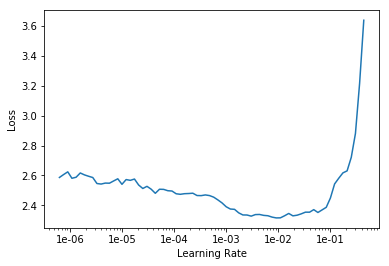

In [42]:
#Learn rate finder
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.467729,1.015799,0.338926,0.661074,00:43
1,1.024468,0.597618,0.196868,0.803132,00:42
2,0.833893,0.575928,0.171141,0.828859,00:43
3,0.671142,0.558927,0.178412,0.821588,00:42


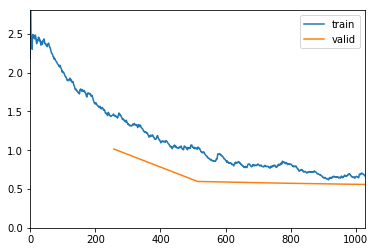

Better model found at epoch 0 with accuracy value: 0.6610738039016724.
Better model found at epoch 1 with accuracy value: 0.8031319975852966.
Better model found at epoch 2 with accuracy value: 0.8288590312004089.


In [43]:
#Fit heads
learn.clip_grad(1.0);
lr =  1e-3
learn.fit_one_cycle(epochs_head, max_lr = lr, 
                    callbacks=[SaveModelCallback(learn, monitor='accuracy',
                                                 mode='max', name='Best_model_sz224_resnet50_fold2')])


In [44]:
learn.load('Best_model_sz224_resnet50_fold2')
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


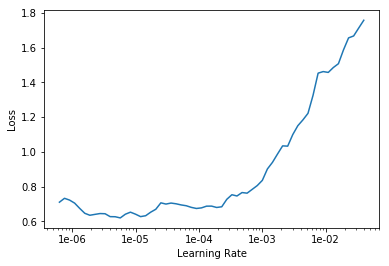

In [45]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.681718,0.555275,0.166107,0.833893,00:57
1,0.628009,0.546218,0.167226,0.832774,00:58
2,0.630218,0.582755,0.176734,0.823266,00:57
3,0.584994,0.588226,0.185123,0.814877,00:58
4,0.542188,0.557275,0.187360,0.812640,00:57
5,0.450436,0.529461,0.167226,0.832774,00:57
6,0.404708,0.560523,0.166107,0.833893,00:57
7,0.356681,0.590561,0.184004,0.815996,00:58
8,0.297416,0.600775,0.163870,0.836130,00:57
9,0.285370,0.581090,0.157159,0.842841,00:57


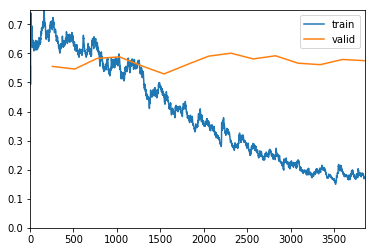

Better model found at epoch 0 with accuracy value: 0.8338926434516907.
Epoch 4: reducing lr to 1.9887481084816066e-05
Better model found at epoch 8 with accuracy value: 0.8361297249794006.
Better model found at epoch 9 with accuracy value: 0.8428411483764648.
Better model found at epoch 10 with accuracy value: 0.8450782895088196.
Better model found at epoch 11 with accuracy value: 0.8478747010231018.
Better model found at epoch 12 with accuracy value: 0.853467583656311.


In [46]:
learn.fit_one_cycle(epochs_all, max_lr = slice(1e-5, 1e-4), wd=0.05, 
                    callbacks=[SaveModelCallback(learn, monitor='accuracy',
                                                 mode='max', name='Best_model_sz224_stage2_resnet50_fold2'),
        ReduceLROnPlateauCallback(learn, monitor='accuracy', mode='max', patience = patience)])

In [47]:
learn.load('Best_model_sz224_stage2_resnet50_fold2')

interp2 = ClassificationInterpretation.from_learner(learn)
print(interp2.confusion_matrix().sum())

losses,idxs = interp2.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)


1788


True

In [48]:
confusion_matrix2 = interp2.confusion_matrix()


FP = confusion_matrix2.sum(axis=0) - np.diag(confusion_matrix2)  
FN = confusion_matrix2.sum(axis=1) - np.diag(confusion_matrix2)
TP = np.diag(confusion_matrix2)
TN = confusion_matrix2.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)


TPR.mean()

0.6378821047093878

In [49]:
interp2_tta = ClassificationInterpretation.from_learner(learn, tta=True)

confusion_matrix2_tta = interp2_tta.confusion_matrix()


FP = confusion_matrix2_tta.sum(axis=0) - np.diag(confusion_matrix2_tta)  
FN = confusion_matrix2_tta.sum(axis=1) - np.diag(confusion_matrix2_tta)
TP = np.diag(confusion_matrix2_tta)
TN = confusion_matrix2_tta.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)


TPR.mean()

0.6447937710613377

# Fold 3

In [50]:
gc.collect()
learn.destroy()
seed_everything(SEED)
bs = 32
data = get_data(metadata_train_valid3, bs, 224)

#Define Convolutional Neural Network with backbone resnet50
learn = cnn_learner(data, models.resnet50, metrics = [error_rate, accuracy],
                   callback_fns=[ShowGraph])

learn.loss_func=nn.CrossEntropyLoss(weight=class_weights)


this Learner object self-destroyed - it still exists, but no longer usable


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


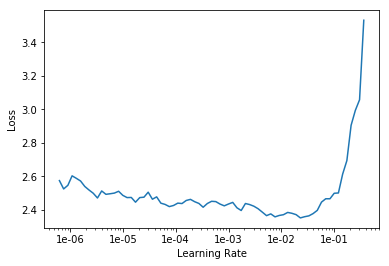

In [51]:
#Learn rate finder
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.590884,0.870534,0.293615,0.706385,00:43
1,1.025691,0.460051,0.157925,0.842075,00:43
2,0.819632,0.441824,0.149373,0.850627,00:43
3,0.694179,0.444519,0.153934,0.846066,00:42


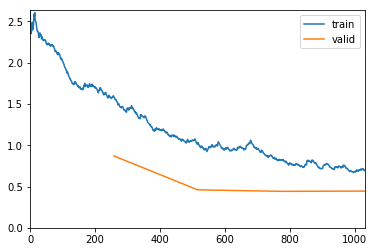

Better model found at epoch 0 with accuracy value: 0.7063854336738586.
Better model found at epoch 1 with accuracy value: 0.8420752286911011.
Better model found at epoch 2 with accuracy value: 0.8506271243095398.


In [52]:
#Fit heads
learn.clip_grad(1.0);
lr= 1e-3
learn.fit_one_cycle(epochs_head,  max_lr = lr, 
                    callbacks=[SaveModelCallback(learn, monitor='accuracy',
                                                 mode='max', name='Best_model_sz224_resnet50_fold3')])

In [53]:
learn.load('Best_model_sz224_resnet50_fold3')

learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


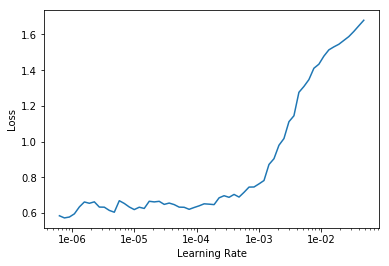

In [54]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.717923,0.437675,0.150513,0.849487,00:58
1,0.708005,0.433533,0.148803,0.851197,00:57
2,0.610181,0.408890,0.129418,0.870582,00:58
3,0.587448,0.432712,0.146522,0.853478,00:57
4,0.597028,0.429640,0.139681,0.860319,00:58
5,0.495178,0.450995,0.137400,0.862600,00:57
6,0.447768,0.458231,0.136260,0.863740,00:57
7,0.339780,0.465034,0.135120,0.864880,00:59
8,0.306543,0.458970,0.140251,0.859749,00:59
9,0.254653,0.519076,0.144242,0.855758,00:59


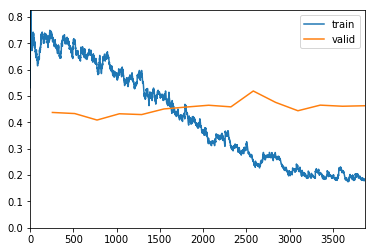

Better model found at epoch 0 with accuracy value: 0.8494868874549866.
Better model found at epoch 1 with accuracy value: 0.8511972427368164.
Better model found at epoch 2 with accuracy value: 0.8705815076828003.
Epoch 6: reducing lr to 1.7330529396223397e-05
Epoch 10: reducing lr to 6.346644369977027e-06
Better model found at epoch 11 with accuracy value: 0.8728620409965515.


In [55]:
learn.fit_one_cycle(epochs_all, max_lr = slice(1e-5, 1e-4), 
                    callbacks=[SaveModelCallback(learn, monitor='accuracy',
                                                 mode='max', name='Best_model_sz224_stage2_resnet50_fold3'),
                              ReduceLROnPlateauCallback(learn, monitor='accuracy', mode='max', patience = patience)])


In [56]:
learn.load('Best_model_sz224_stage2_resnet50_fold3')

interp3 = ClassificationInterpretation.from_learner(learn)
print(interp3.confusion_matrix().sum())

losses,idxs = interp3.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)



1754


True

In [57]:

confusion_matrix3 = interp3.confusion_matrix()


FP = confusion_matrix3.sum(axis=0) - np.diag(confusion_matrix3)  
FN = confusion_matrix3.sum(axis=1) - np.diag(confusion_matrix3)
TP = np.diag(confusion_matrix3)
TN = confusion_matrix3.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)


TPR.mean()

0.7765075886881279

In [58]:
interp3_tta = ClassificationInterpretation.from_learner(learn, tta=True)


confusion_matrix3_tta = interp3_tta.confusion_matrix()


FP = confusion_matrix3_tta.sum(axis=0) - np.diag(confusion_matrix3_tta)  
FN = confusion_matrix3_tta.sum(axis=1) - np.diag(confusion_matrix3_tta)
TP = np.diag(confusion_matrix3_tta)
TN = confusion_matrix3_tta.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)


TPR.mean()

0.7898711317061807

# Fold 4

In [59]:
gc.collect()
learn.destroy()
seed_everything(SEED)
bs = 32
data = get_data(metadata_train_valid4, bs, 224)

#Define Convolutional Neural Network with backbone resnet50
learn = cnn_learner(data, models.resnet50, metrics = [error_rate, accuracy],
                   callback_fns=[ShowGraph])

learn.loss_func=nn.CrossEntropyLoss(weight=class_weights)


this Learner object self-destroyed - it still exists, but no longer usable


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


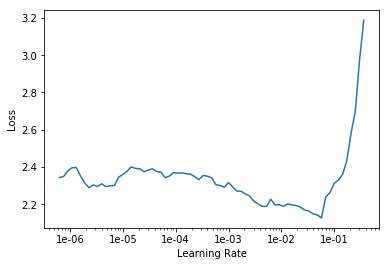

In [60]:
#Learn rate finder
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.492628,2.018486,0.601140,0.398860,00:42
1,1.048403,1.989057,0.617013,0.382987,00:43
2,0.812597,1.555402,0.549451,0.450549,00:44
3,0.671437,1.738290,0.575092,0.424908,00:42


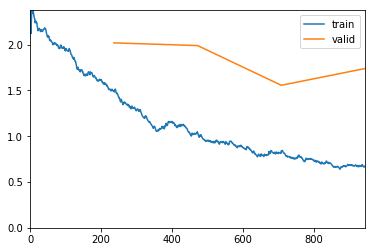

Better model found at epoch 0 with accuracy value: 0.3988603949546814.
Better model found at epoch 2 with accuracy value: 0.450549453496933.


In [61]:
#Fit heads
learn.clip_grad(1.0);
lr = 1e-3
learn.fit_one_cycle(epochs_head,  max_lr = lr, 
                    callbacks=[SaveModelCallback(learn, monitor='accuracy',
                                                 mode='max', name='Best_model_sz224_resnet50_fold4')])

In [62]:
learn.load('Best_model_sz224_resnet50_fold4')

learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


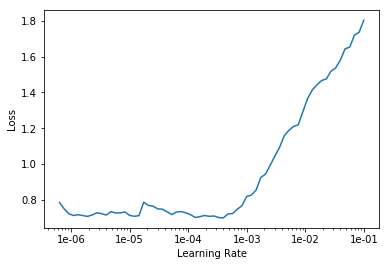

In [63]:
#Learn rate finder
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.710640,1.562170,0.549451,0.450549,00:55
1,0.686482,1.628219,0.543753,0.456247,00:56
2,0.660732,1.805500,0.584860,0.415140,00:56
3,0.593029,1.581686,0.511193,0.488807,00:56
4,0.530795,1.492337,0.526659,0.473341,00:56
5,0.431930,1.691596,0.541311,0.458689,00:57
6,0.413762,1.521912,0.483109,0.516891,00:55
7,0.400882,1.838967,0.516077,0.483923,00:56
8,0.317534,1.374171,0.442409,0.557591,00:56
9,0.270573,1.484009,0.455026,0.544974,00:57


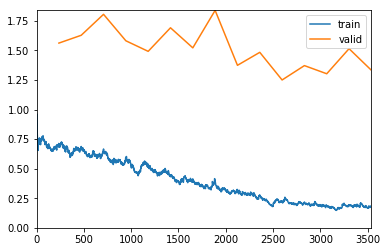

Better model found at epoch 0 with accuracy value: 0.450549453496933.
Better model found at epoch 1 with accuracy value: 0.4562474489212036.
Better model found at epoch 3 with accuracy value: 0.4888074994087219.
Better model found at epoch 6 with accuracy value: 0.5168905258178711.
Better model found at epoch 8 with accuracy value: 0.5575905442237854.
Better model found at epoch 10 with accuracy value: 0.5999186038970947.
Better model found at epoch 12 with accuracy value: 0.6023606061935425.


In [64]:
learn.fit_one_cycle(epochs_all, max_lr = slice(1e-5, 1e-4), wd=0.05, 
                    callbacks=[SaveModelCallback(learn, monitor='accuracy',
                                                 mode='max', name='Best_model_sz224_stage2_resnet50_fold4'),
                              ReduceLROnPlateauCallback(learn, monitor='accuracy', mode='max', patience = patience)])


In [65]:
learn.load('Best_model_sz224_stage2_resnet50_fold4')

interp4 = ClassificationInterpretation.from_learner(learn)
print(interp4.confusion_matrix().sum())

losses,idxs = interp4.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)




2457


True

In [66]:
confusion_matrix4 = interp4.confusion_matrix()


FP = confusion_matrix4.sum(axis=0) - np.diag(confusion_matrix4)  
FN = confusion_matrix4.sum(axis=1) - np.diag(confusion_matrix4)
TP = np.diag(confusion_matrix4)
TN = confusion_matrix4.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)

TPR.mean()

0.7053206236926929

In [67]:
interp4_tta = ClassificationInterpretation.from_learner(learn, tta=True)
confusion_matrix4_tta = interp4_tta.confusion_matrix()


FP = confusion_matrix4_tta.sum(axis=0) - np.diag(confusion_matrix4_tta)  
FN = confusion_matrix4_tta.sum(axis=1) - np.diag(confusion_matrix4_tta)
TP = np.diag(confusion_matrix4_tta)
TN = confusion_matrix4_tta.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)

TPR.mean()

0.7151314019463104

# Fold 5

In [68]:
gc.collect()
learn.destroy()
seed_everything(SEED)
bs = 32
data = get_data(metadata_train_valid5, bs, 224)

#Define Convolutional Neural Network with backbone resnet50
learn = cnn_learner(data, models.resnet50, metrics = [error_rate, accuracy],
                   callback_fns=[ShowGraph])

learn.loss_func=nn.CrossEntropyLoss(weight=class_weights)


this Learner object self-destroyed - it still exists, but no longer usable


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


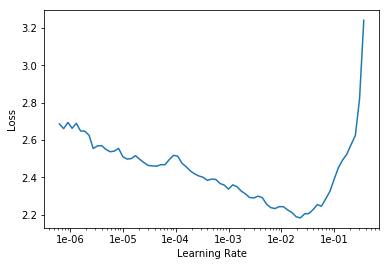

In [69]:
#Learn rate finder
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.493403,3.474834,0.797254,0.202746,00:44
1,1.032310,2.029426,0.714874,0.285126,00:43
2,0.834895,2.003390,0.669565,0.330435,00:45
3,0.613229,1.923828,0.672311,0.327689,00:43


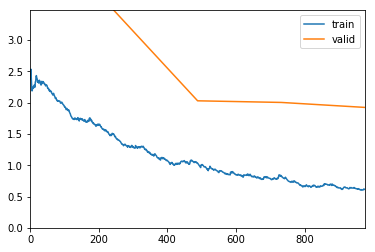

Better model found at epoch 0 with accuracy value: 0.20274598896503448.
Better model found at epoch 1 with accuracy value: 0.28512585163116455.
Better model found at epoch 2 with accuracy value: 0.33043476939201355.


In [70]:
#Fit heads
learn.clip_grad(1.0);
lr = 1e-3
learn.fit_one_cycle(epochs_head, wd=0.05, max_lr = lr, 
                    callbacks=[SaveModelCallback(learn, monitor='accuracy',
                                                 mode='max', name='Best_model_sz224_resnet50_fold5')])


In [71]:
learn.load('Best_model_sz224_resnet50_fold5')

learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


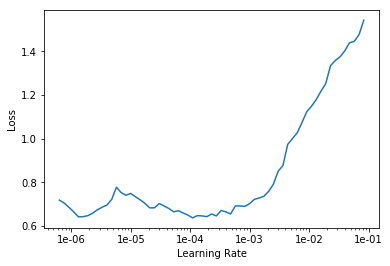

In [72]:
#Learn rate finder
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.599751,1.898071,0.660412,0.339588,00:56
1,0.612804,1.914753,0.674600,0.325400,00:57
2,0.624066,2.138207,0.686499,0.313501,00:57
3,0.551573,2.306092,0.729062,0.270938,00:58
4,0.522837,2.133091,0.640275,0.359725,00:58
5,0.446836,1.879109,0.613730,0.386270,00:57
6,0.376646,2.046531,0.620137,0.379863,00:57
7,0.354499,2.168431,0.653089,0.346911,00:57
8,0.312210,1.944573,0.591304,0.408696,00:58
9,0.247157,1.918137,0.554691,0.445309,00:57


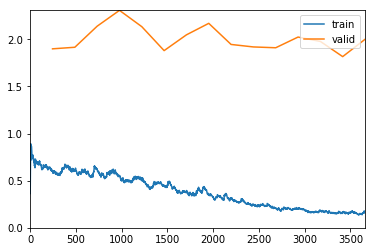

Better model found at epoch 0 with accuracy value: 0.33958810567855835.
Better model found at epoch 4 with accuracy value: 0.35972538590431213.
Better model found at epoch 5 with accuracy value: 0.38627001643180847.
Better model found at epoch 8 with accuracy value: 0.40869563817977905.
Better model found at epoch 9 with accuracy value: 0.4453089237213135.
Better model found at epoch 11 with accuracy value: 0.4526315927505493.
Better model found at epoch 12 with accuracy value: 0.45537757873535156.
Better model found at epoch 13 with accuracy value: 0.4864988625049591.


In [73]:
learn.fit_one_cycle(epochs_all, max_lr = slice(1e-5, 1e-4), wd=0.05, 
                    callbacks=[SaveModelCallback(learn, monitor='accuracy',
                                                 mode='max', name='Best_model_sz224_stage2_resnet50_fold5'),
                    ReduceLROnPlateauCallback(learn, monitor='accuracy', mode='max', patience = patience)])



In [74]:
learn.load('Best_model_sz224_stage2_resnet50_fold5')

interp5 = ClassificationInterpretation.from_learner(learn)
print(interp5.confusion_matrix().sum())

losses,idxs = interp5.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

2185


True

In [75]:
confusion_matrix5 = interp5.confusion_matrix()


FP = confusion_matrix5.sum(axis=0) - np.diag(confusion_matrix5)  
FN = confusion_matrix5.sum(axis=1) - np.diag(confusion_matrix5)
TP = np.diag(confusion_matrix5)
TN = confusion_matrix5.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)


TPR.mean()

0.6755170098556844

In [76]:
interp5_tta = ClassificationInterpretation.from_learner(learn, tta=True)

confusion_matrix5_tta = interp5_tta.confusion_matrix()


FP = confusion_matrix5_tta.sum(axis=0) - np.diag(confusion_matrix5_tta)  
FN = confusion_matrix5_tta.sum(axis=1) - np.diag(confusion_matrix5_tta)
TP = np.diag(confusion_matrix5_tta)
TN = confusion_matrix5_tta.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)


TPR.mean()

0.6691429111511357

## Analysis of the Cross Validated Results

We obtain a 66.8% balanced multiclass accuracy without augmentation and a 67.9% balanced multiclass accuracy using test time augmentation. Details of the other classification metrics are presented below.

In [77]:
confusion_matrix = confusion_matrix1 + confusion_matrix2 + confusion_matrix3 + confusion_matrix4 + confusion_matrix5

In [78]:
confusion_matrix_TTA = confusion_matrix1_tta + confusion_matrix2_tta + confusion_matrix3_tta + confusion_matrix4_tta + confusion_matrix5_tta

In [79]:
confusion_matrix

array([[ 206,   29,   53,    9,   22,    8,    0],
       [  37,  372,   37,   17,   22,   23,    6],
       [  60,   24,  666,    2,  196,  147,    4],
       [  12,    9,    9,   65,   11,    9,    0],
       [  25,   14,  127,   16,  657,  266,    8],
       [  35,  106,  445,   79, 1136, 4863,   41],
       [   3,    4,    1,    0,    8,    7,  119]])

In [80]:
confusion_matrix_TTA

array([[ 229,   25,   40,    8,   17,    8,    0],
       [  41,  388,   33,   12,   11,   20,    9],
       [  77,   21,  669,    2,  167,  162,    1],
       [  11,   10,    7,   65,   11,   11,    0],
       [  38,    9,  131,   14,  616,  295,   10],
       [  45,   98,  432,   37,  968, 5082,   43],
       [   2,    6,    1,    0,   10,    7,  116]])

In [81]:
confusion_matrix.sum()

10015

In [82]:
confusion_matrix_TTA.sum()

10015

In [83]:

#https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal

FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
TP = np.diag(confusion_matrix)
TN = confusion_matrix.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)


print("True Positive Rate         ", TPR)
print("True Negative Rate         ", TNR)
print("Positive Predictive Value  ", PPV)
print("Negative Predictive Value  ", NPV)
print("False Positive Rate        ", FPR)
print("False Negative Rate        ", FNR)
print("False Discovery Rate       ", FDR)
print("Accuracy                   ", ACC)

True Positive Rate          [0.629969 0.723735 0.606005 0.565217 0.590296 0.72528  0.838028]
True Negative Rate          [0.982246 0.980423 0.92463  0.987576 0.843294 0.861027 0.994024]
Positive Predictive Value   [0.544974 0.666667 0.497758 0.345745 0.320175 0.913583 0.668539]
Negative Predictive Value   [0.987444 0.984985 0.950098 0.994912 0.942735 0.607417 0.997662]
False Positive Rate         [0.017754 0.019577 0.07537  0.012424 0.156706 0.138973 0.005976]
False Negative Rate         [0.370031 0.276265 0.393995 0.434783 0.409704 0.27472  0.161972]
False Discovery Rate        [0.455026 0.333333 0.502242 0.654255 0.679825 0.086417 0.331461]
Accuracy                    [0.970744 0.967249 0.889666 0.982726 0.815177 0.770145 0.991812]


In [84]:
TPR.mean() #without augmentation

0.6683617121946673

In [85]:
TNR.mean()

0.9390313951117332

In [86]:
FP = confusion_matrix_TTA.sum(axis=0) - np.diag(confusion_matrix_TTA)  
FN = confusion_matrix_TTA.sum(axis=1) - np.diag(confusion_matrix_TTA)
TP = np.diag(confusion_matrix_TTA)
TN = confusion_matrix_TTA.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)


print("True Positive Rate         ", TPR)
print("True Negative Rate         ", TNR)
print("Positive Predictive Value  ", PPV)
print("Negative Predictive Value  ", NPV)
print("False Positive Rate        ", FPR)
print("False Negative Rate        ", FNR)
print("False Discovery Rate       ", FDR)
print("Accuracy                   ", ACC)

True Positive Rate          [0.700306 0.754864 0.608735 0.565217 0.553459 0.757942 0.816901]
True Negative Rate          [0.977911 0.982212 0.92777  0.992626 0.866996 0.848036 0.993619]
Positive Predictive Value   [0.51693  0.696589 0.50952  0.471014 0.342222 0.909937 0.648045]
Negative Predictive Value   [0.989762 0.986678 0.950586 0.994938 0.939501 0.633634 0.997357]
False Positive Rate         [0.022089 0.017788 0.07223  0.007374 0.133004 0.151964 0.006381]
False Negative Rate         [0.299694 0.245136 0.391265 0.434783 0.446541 0.242058 0.183099]
False Discovery Rate        [0.48307  0.303411 0.49048  0.528986 0.657778 0.090063 0.351955]
Accuracy                    [0.968847 0.970544 0.892761 0.987718 0.832152 0.787718 0.991113]


In [87]:
TPR.mean() # with test time augmentation

0.67963208445167

In [88]:
TNR.mean()

0.9413101678032485

## Limitations


The test data from the ISIC 2018 is not available. Althought we are confident that our cross-validation strategy is reliable, we are not able to submit the results to the competition and get a leaderboard standing.

We only have one GPU NVIDIA 2080 with memory size of 8GB. The use of multiple GPUs can speed the training process and increase accuracy by processing a larger batch size.

We have made all efforts to make the training process as deterministic as possible using the seed_everything function. However, training of CNN still carries a stochastic component, and the results may be replicated but not identically. 

There is great variability in the results for each one of the folds, with validation scores ranging from 62% to 79%. This may suggest that the weighted cross-entropy metric that we optimized may not be very stable, and other optimization metrics that focus on the detection of rare events, such as focal loss may be more beneficial for the training of the neural network.

## Conclussions

Computer vision algorithms have enormous potential in healthcare applications. This jupyter notebook illustrates the process of training a CNN model to model a dermatological dataset of seven skin conditions. Several other applications of this methodology have the potential to improve diagnosis accuracy and reduce healthcare costs.

## References

[1] Tschandl, P., Rosendahl, C. & Kittler, H. The HAM10000 dataset, a large collection of multi-source 
dermatoscopic images of common pigmented skin lesions. Sci. Data 5, 180161 (2018). 
doi: 10.1038/sdata.2018.161 

[2] He, Kaiming et al. Deep Residual Learning for Image Recognition. Microsoft Research. https://arxiv.org/abs/1512.03385v1

[3] ISIC 2018 challenge Task 3: Lesion Diagnosis https://challenge2018.isic-archive.com/leaderboards/

[4] Shang, Kailan. Applying Image Recognition to Insurance. Society of Actuaries. June 2018. https://www.soa.org/globalassets/assets/Files/resources/research-report/2018/applying-image-recognition.pdf

[5] Pranav Rajpurkar, et al. CheXNet: Radiologist-Level Pneumonia Detection on Chest X-Rays with Deep Learning. https://arxiv.org/abs/1711.05225

[6] Levy, Daniel, Jain, Arzav. Breast Mass Classification from Mammograms using Deep Convolutional Neural Networks. 2016. https://arxiv.org/abs/1612.00542

[7] Esteva, Andre, et al. Dermatologist-level classification of skin cancer with deep neural networks. Nature volume 542, pages 115–118 (02 February 2017).

[8] Howard, Jeremy and others, fastai, 2018,  publisher= GitHub, https://github.com/fastai/fastai

